## OpenAI Function Calling PDF Reader

This code expands upon the OpenAI [Function calling](https://platform.openai.com/docs/guides/function-calling) documentation to interact with PDFs

In [1]:
# !pip install arxiv
# !pip install --upgrade openai
# !pip install PyPDF2
# !pip install numpy
# !pip install PyMuPDF Pillow
# !pip install matplotlib

import json
import arxiv
import numpy as np

from openai import OpenAI
from PyPDF2 import PdfReader

import os
import fitz 
import io

from PIL import Image
import matplotlib.pyplot as plt
import glob

# Put your api_kek, starts with 'sk-'
client = OpenAI(api_key ='')


In [3]:
search = arxiv.Search(id_list=['1706.03762'])

paper = next(arxiv.Client().results(search))
paper_path = paper.download_pdf() 
print(paper.title)


Attention Is All You Need


In [4]:
# Use cosine_similarity to find the semantically closest vectors 
def cosine_similarity(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    mag_vector1 = np.linalg.norm(vector1)
    mag_vector2 = np.linalg.norm(vector2)
    
    cosine_sim = dot_product / (mag_vector1 * mag_vector2)
    return cosine_sim

# Normalize the embedding vectors to account for different page lengths
def normalize(vector):
    mag = np.linalg.norm(vector)
    if mag > 0:
        vector = vector/mag
    return vector


In [5]:


class Chatbot:
    def __init__(self, paper_path: str):
        pages = []
        reader = PdfReader(paper_path)
        for idx, page in enumerate(reader.pages):
            text = page.extract_text()
            pages.append(f'page_number: {idx+1} \npage_content: {text}')
    
        # Convert text to embeddings
        embedded_pages = {}
        for page in pages:
            embedded_pages[page] = self.get_embedding(page)

        self.pages_db = embedded_pages

        # Extract and save images under extracted_images
        file = paper_path
        pdf_file = fitz.open(file)
        output_dir = "extracted_images"
        output_format = "png"
        min_width = 100
        min_height = 100

        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        for page_index in range(len(pdf_file)):
            page = pdf_file[page_index]
            image_list = page.get_images(full=True)

            for image_index, img in enumerate(image_list, start=1):
                xref = img[0]
                base_image = pdf_file.extract_image(xref)
                image_bytes = base_image["image"]
                image_ext = base_image["ext"]
                image = Image.open(io.BytesIO(image_bytes))

                if image.width >= min_width and image.height >= min_height:
                    image.save(os.path.join(output_dir, f"page{page_index + 1}_{image_index}.{output_format}"), format=output_format.upper())


    def get_embedding(self, text, model='text-embedding-ada-002'):
        text = text.replace('\n', ' ')
        return client.embeddings.create(input = [text], model=model).data[0].embedding

    

    def answer(self, question: str) -> float:

        print(f'User: {question}')

        question_embedding = self.get_embedding(question)

        scores = {}
        for text, embedding in self.pages_db.items():
            sim = cosine_similarity(embedding, question_embedding)
            scores[sim] = text
        
        sorted_scores = sorted(scores.keys(), reverse=True)

        top_2 = sorted_scores[:2]

        top_2_text = [(score, scores[score]) for score in top_2]

        def format_math(math_formula: str):
            return(math_formula.replace('\n', '/'))
        
        def display_image(image_page_number: str, figure_description: str):
            img_name = f'page[{image_page_number}'
            folder_path = 'extracted_images'
            search_pattern = f'{folder_path}/page{image_page_number}_*.png'

            image_files = glob.glob(search_pattern)

            for image_file in image_files:
                img = np.asarray(Image.open(image_file))
                plt.imshow(img)
                plt.show()

            return(f"Displaying {figure_description}")

        tools=[
            {   
                "type": "function",
                "function": {
                    "name": "format_math",
                    "description": "format math formulas",
                    "parameters": {
                        "type": "object",
                        "properties": {
                            "math_formula": {
                                "type": "string",
                                "description": "when the response includes an equation",
                            },
                        },
                        "required": ["math_formula"],
                    }
                }
            },
            {   
                "type": "function",
                "function": {
                    "name": "display_image",
                    "description": "displays Figures on a page",
                    "parameters": {
                        "type": "object",
                        "properties": {
                            "image_page_number": {
                                "type": "string",
                                "description": "page number of the figure, not the figure number",
                            },
                            "figure_description": {
                                "type": "string",
                                "description_quote": "quote the description of the Figure(s) on the page",
                            },
                        },
                        "required": ["image_page_number", "figure_description"],
                    }
                }
            }
        ]
            
        prompt = f"""Answer the question about the paper in the provided ranked context.
            If there the user is asking for a formula, include the whole formula
            Context_1: {top_2_text[0]} 
            Context_2: {top_2_text[1]} 
            Question:{question} """

        completion = client.chat.completions.create(
            model='gpt-3.5-turbo-0613',
            messages = [{
                'role': 'user',
                'content': prompt
            }],

            tools=tools,
            temperature=0.1,
            top_p=0.1,
            max_tokens=150,
            
        )

        response_message = completion.choices[0].message

        tool_calls = response_message.tool_calls
        # See if the model wants to call a function
        if tool_calls:
            #print(tool_calls)
            available_functions = {
            "format_math": format_math,
            "display_image": display_image,
            } 
            for tool_call in tool_calls: # If multiple functions are called
                function_name = tool_call.function.name
                function_to_call = available_functions[function_name]
                function_args = json.loads(tool_call.function.arguments)
                if function_name == 'format_math':
                    function_response = function_to_call(
                        math_formula=function_args.get('math_formula'),
                    )
                elif function_name == 'display_image':
                    function_response = function_to_call(
                        image_page_number=function_args.get('image_page_number'),
                        figure_description=function_args.get('figure_description'),
                    )
                return(function_response)

        else:
            return (response_message.content)


User: What is a transformer?
Response: A transformer is a model architecture that relies entirely on self-attention to compute representations of its input and output without using sequence-aligned recurrent neural networks (RNNs) or convolution. It allows for significantly more parallelization and can achieve state-of-the-art performance in tasks such as translation. The transformer model replaces the recurrent layers commonly used in encoder-decoder architectures with multi-headed self-attention.

User: What does the figure of transformer look like?


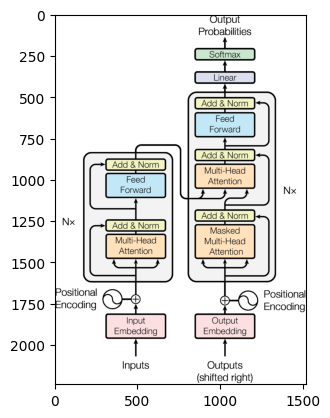

Response: Displaying Figure 1: The Transformer - model architecture.

User: What formula is used to compute the attention function?
Response: Attention( Q, K, V ) = softmax(QKT/√dk)V (1)

User: Thank you
Response: You're welcome! How can I assist you with the paper?



In [11]:
chatbot = Chatbot(paper_path)
questions = [
    'What is a transformer?',
    'What does the figure of transformer look like?',
    'What formula is used to compute the attention function?',
    'Thank you'
]

for question in questions:
    print(f'Response: {chatbot.answer(question)}\n')
        

